# Importing Libraries & datasets

In [321]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

In [277]:
df1 = pd.read_excel("dataset\ProductA.xlsx")
df2 = pd.read_excel("dataset\ProductA_google_clicks.xlsx")
df3 = pd.read_excel("dataset\ProductA_fb_impressions.xlsx")

***
# Data Preprocessing

### Merging datasets

In [278]:
df4 = pd.merge(df1, df2, on="Day Index")
df = pd.merge(df4, df3, on="Day Index")

In [279]:
df.to_excel('final_df.xlsx', index=False)   # exporitng the final dataset for further analysis

In [280]:
df.head()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678


### Descriptive Statistics

In [281]:
df.shape

(212, 4)

212 rows & 4 attrbiutes

In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Clicks       212 non-null    int64         
 3   Impressions  212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


In [283]:
df.describe()

,Day Index,Quantity,Clicks,Impressions
count,212,212.000000,212.00000,212.000000
mean,2022-03-16 12:00:00,17.542453,358.20283,1531.702830
min,2021-12-01 00:00:00,5.000000,60.00000,620.000000
25%,2022-01-22 18:00:00,13.750000,154.00000,1209.750000
50%,2022-03-16 12:00:00,17.000000,402.50000,1460.000000
75%,2022-05-08 06:00:00,21.000000,492.75000,1862.000000
max,2022-06-30 00:00:00,38.000000,726.00000,2707.000000
std,NaN,5.790423,164.52160,440.660783


### Missing values - Imputation

In [284]:
print("NULL Values:")
df.isnull().sum()

NULL Values:


Day Index      0
Quantity       0
Clicks         0
Impressions    0
dtype: int64

Hence, there are no NULL values. So, No imputation needed.

### Dropping Duplicates

In [285]:
df.shape

(212, 4)

In [286]:
df.drop_duplicates()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678
...,...,...,...,...
207,2022-06-26,13,114,1218
208,2022-06-27,16,106,1311
209,2022-06-28,13,109,885
210,2022-06-29,16,60,1000


No duplicates found! No row dropped!


### Analysing Outliers

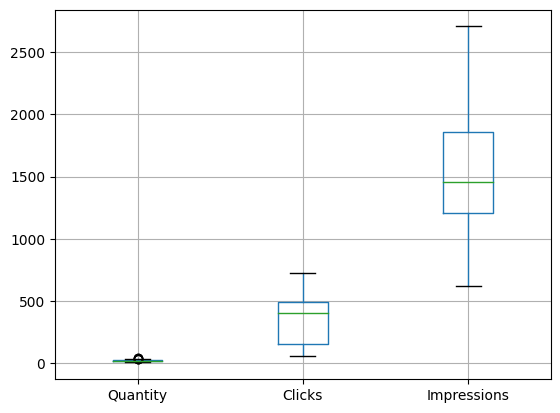

In [287]:
plt.figure()
df.boxplot()
plt.show()

In [288]:
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

print("Outliers in each dependent attribute:")
print(f"Quantity:\t {len(find_outliers_IQR(df['Quantity']))}")
print(f"Clicks:\t\t {len(find_outliers_IQR(df['Clicks']))}")
print(f"Impressions:\t {len(find_outliers_IQR(df['Impressions']))}")

Outliers in each dependent attribute:
Quantity:	 5
Clicks:		 0
Impressions:	 0


So, there are 5 outliers in the *Quantity* attribute

In [289]:
print(f"Quantity:\n{find_outliers_IQR(df['Quantity'])}")

Quantity:
4      33
9      38
78     38
113    32
142    36
Name: Quantity, dtype: int64


In [290]:
percentile_95_value = df["Quantity"].quantile(0.95)
print(percentile_95_value)

27.44999999999999


***

### Replacing Outliers with 95th percentile value

In [291]:
df_without_outlier = df.copy()

In [292]:
def impute_outliers_95th_percentile(series):
    q1, q3 = series.quantile([0.25, 0.75])
    IQR = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * IQR, q3 + 1.5 * IQR
    percentile_95_value = series.quantile(0.95)
    return series.apply(lambda x: percentile_95_value if x < lower_bound or x > upper_bound else x)

In [293]:
df_without_outlier['Quantity'] = impute_outliers_95th_percentile(df_without_outlier['Quantity'])

In [294]:
print("Outliers in each dependent attribute:")
print(f"Quantity:\t {len(find_outliers_IQR(df_without_outlier['Quantity']))}")
print(f"Clicks:\t\t {len(find_outliers_IQR(df_without_outlier['Clicks']))}")
print(f"Impressions:\t {len(find_outliers_IQR(df_without_outlier['Impressions']))}")

Outliers in each dependent attribute:
Quantity:	 0
Clicks:		 0
Impressions:	 0


In [295]:
df_without_outlier.head()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14.00,445,620
1,2021-12-02,10.00,433,890
2,2021-12-03,13.00,424,851
3,2021-12-04,22.00,427,881
4,2021-12-05,27.45,451,678


Hence, the outliers are replaced by median values.

### Log transformation

In [296]:
df_log = df.copy()

In [297]:
df_log['Quantity'] = np.log1p(df_log['Quantity'])
df_log['Clicks'] = np.log1p(df_log['Clicks'])
df_log['Impressions'] = np.log1p(df_log['Impressions'])

In [298]:
df_log.head()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,2.708050,6.100319,6.431331
1,2021-12-02,2.397895,6.073045,6.792344
2,2021-12-03,2.639057,6.052089,6.747587
3,2021-12-04,3.135494,6.059123,6.782192
4,2021-12-05,3.526361,6.113682,6.520621


***
# Data Analysis

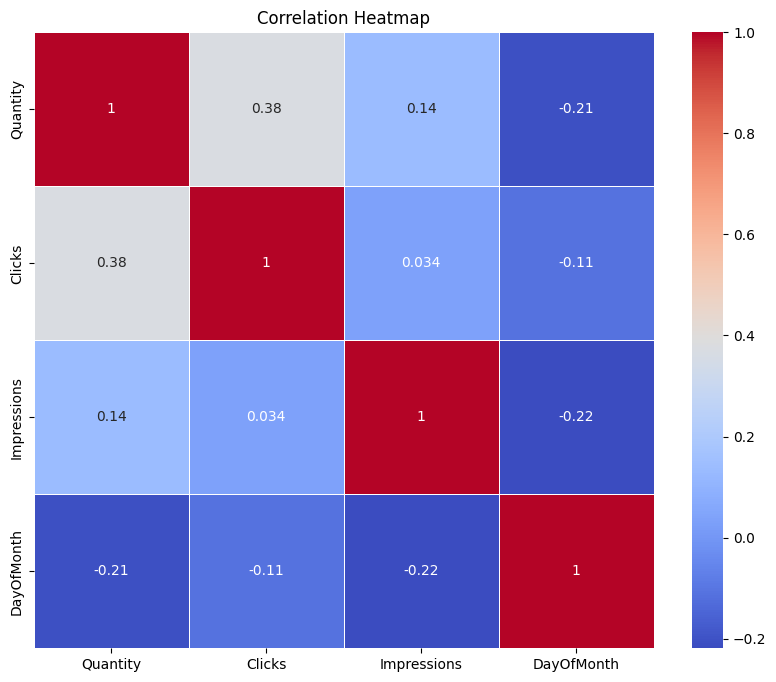

In [323]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True,  cmap='coolwarm', linewidths=0.5).set_title("Correlation Heatmap")
plt.show()

Through the above correlation heatmap, we can say that :
* Clicks have good correlation with Quantity
* Impressions also have slight relation to Quantity
* Impression have very tiny relation to clicks

### 1. How Clicks affect the Product's quantity?

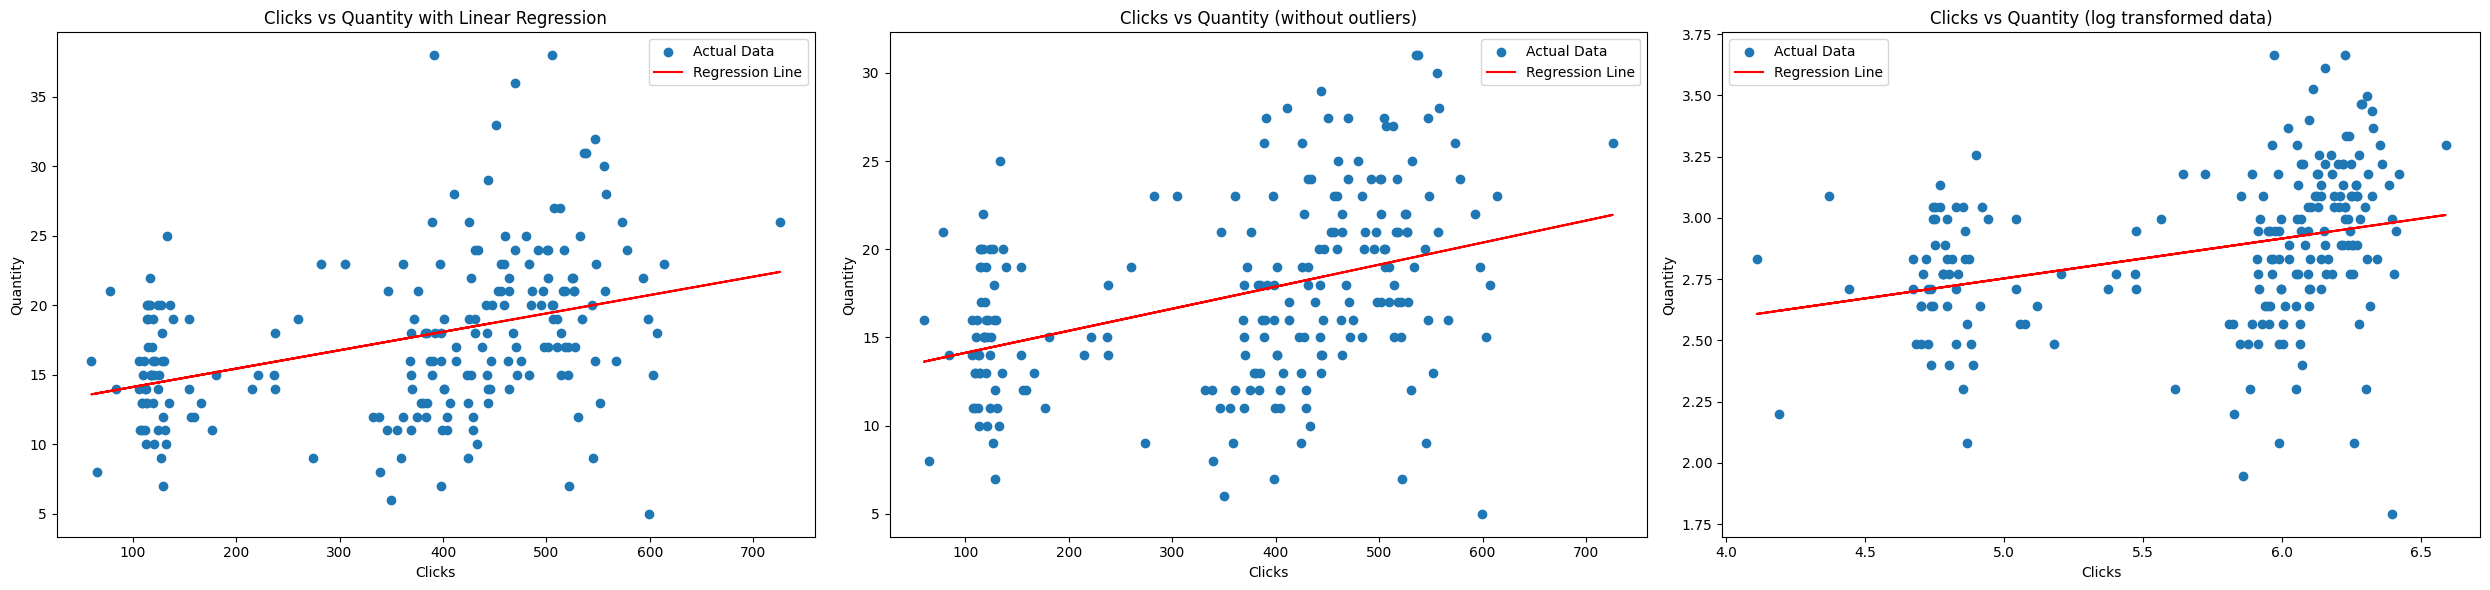

The slope of the linear regression model for original data is: 0.013234961483654805
The slope of the linear regression model for data without outliers is: 0.01249525206748579
The slope of the linear regression model for log transformed data is: 0.16298656613150664


In [301]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Original data
x = df["Clicks"].values.reshape(-1, 1)
y = df["Quantity"].values

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
slope_original = model.coef_[0]

# Data without outliers
x_without_outliers = df_without_outlier["Clicks"].values.reshape(-1, 1)
y_without_outliers = df_without_outlier["Quantity"].values

model.fit(x_without_outliers, y_without_outliers)
y_pred_without_outliers = model.predict(x_without_outliers)
slope_without_outliers = model.coef_[0]

# Log transformed data
x_log = df_log["Clicks"].values.reshape(-1, 1)
y_log = df_log["Quantity"].values

model.fit(x_log, y_log)
y_pred_log = model.predict(x_log)
slope_log = model.coef_[0]

# Plotting all three side by side
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

# Plot for original data
axes[0].scatter(df['Clicks'], df['Quantity'], label='Actual Data')
axes[0].plot(df['Clicks'], y_pred, color='red', label='Regression Line')
axes[0].set_title('Clicks vs Quantity with Linear Regression')
axes[0].set_xlabel('Clicks')
axes[0].set_ylabel('Quantity')
axes[0].legend()

# Plot for data without outliers
axes[1].scatter(df_without_outlier['Clicks'], df_without_outlier['Quantity'], label='Actual Data')
axes[1].plot(df_without_outlier['Clicks'], y_pred_without_outliers, color='red', label='Regression Line')
axes[1].set_title('Clicks vs Quantity (without outliers)')
axes[1].set_xlabel('Clicks')
axes[1].set_ylabel('Quantity')
axes[1].legend()

# Plot for log transformed data
axes[2].scatter(df_log['Clicks'], df_log['Quantity'], label='Actual Data')
axes[2].plot(df_log['Clicks'], y_pred_log, color='red', label='Regression Line')
axes[2].set_title('Clicks vs Quantity (log transformed data)')
axes[2].set_xlabel('Clicks')
axes[2].set_ylabel('Quantity')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"The slope of the linear regression model for original data is: {slope_original}")
print(f"The slope of the linear regression model for data without outliers is: {slope_without_outliers}")
print(f"The slope of the linear regression model for log transformed data is: {slope_log}")


Hence, there is a relation with +ve slope, i.e. Quantity increases as Clicks increases.
***

### 2. How Impressions affect the Product's quantity?

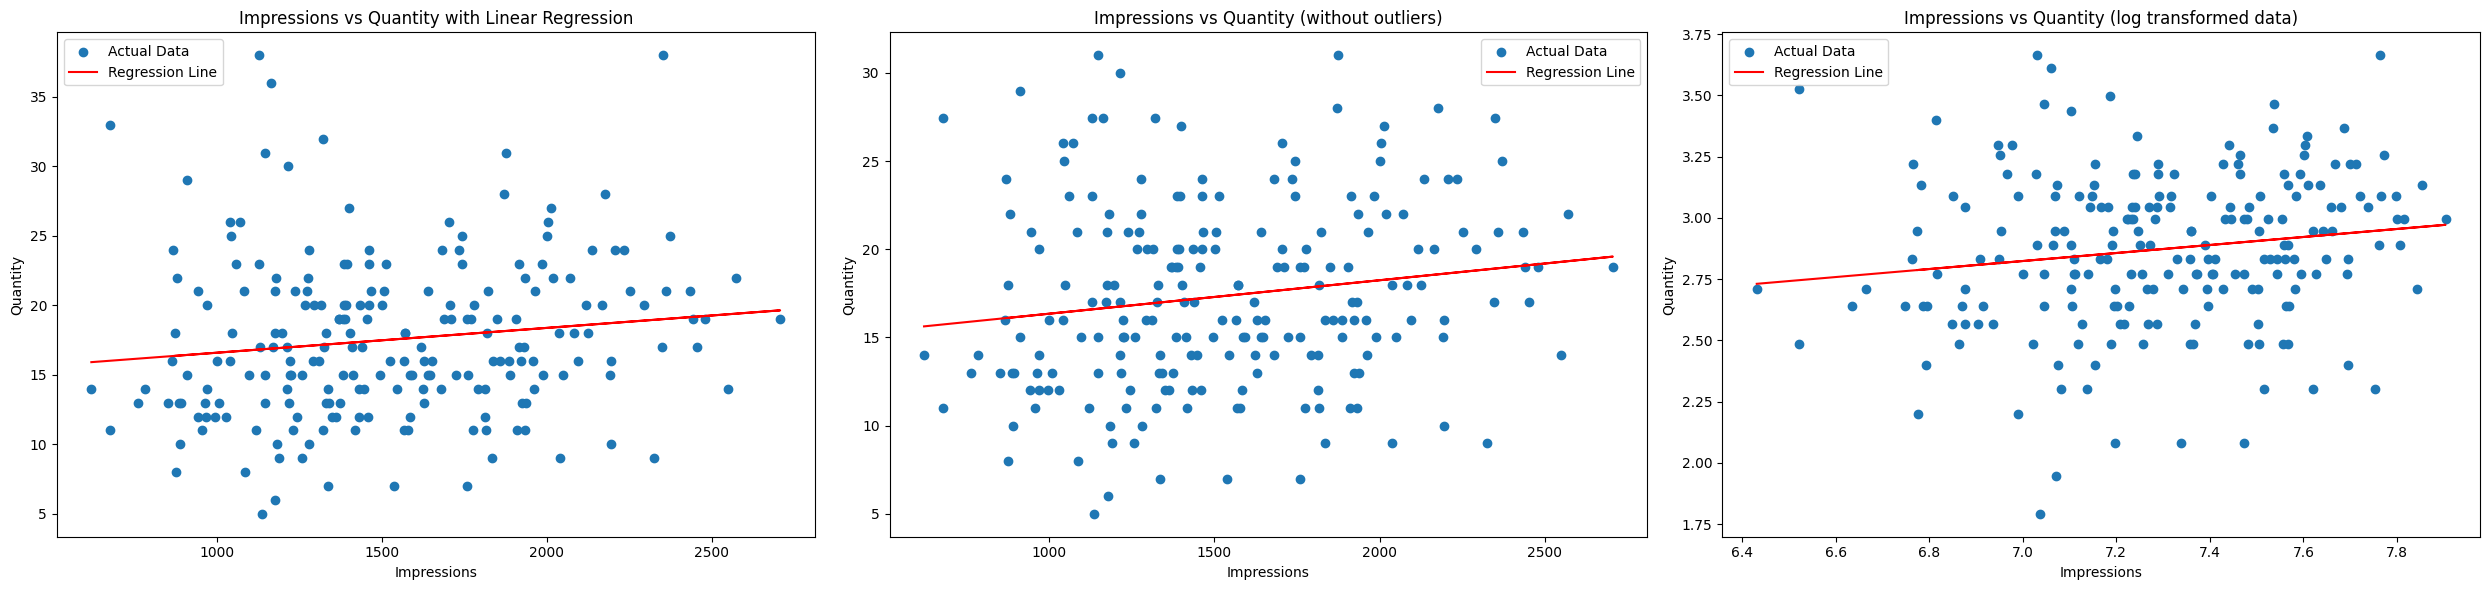

The slope of the linear regression model for original data is: 0.0017863293104571235
The slope of the linear regression model for data without outliers is: 0.0018950388073789278
The slope of the linear regression model for log transformed data is: 0.16352913564679306


In [303]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Original data
x = df["Impressions"].values.reshape(-1, 1)
y = df["Quantity"].values

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
slope_original = model.coef_[0]

# Data without outliers
x_without_outliers = df_without_outlier["Impressions"].values.reshape(-1, 1)
y_without_outliers = df_without_outlier["Quantity"].values

model.fit(x_without_outliers, y_without_outliers)
y_pred_without_outliers = model.predict(x_without_outliers)
slope_without_outliers = model.coef_[0]

# Log transformed data
x_log = df_log["Impressions"].values.reshape(-1, 1)
y_log = df_log["Quantity"].values

model.fit(x_log, y_log)
y_pred_log = model.predict(x_log)
slope_log = model.coef_[0]

# Plotting all three side by side
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

# Plot for original data
axes[0].scatter(df['Impressions'], df['Quantity'], label='Actual Data')
axes[0].plot(df['Impressions'], y_pred, color='red', label='Regression Line')
axes[0].set_title('Impressions vs Quantity with Linear Regression')
axes[0].set_xlabel('Impressions')
axes[0].set_ylabel('Quantity')
axes[0].legend()

# Plot for data without outliers
axes[1].scatter(df_without_outlier['Impressions'], df_without_outlier['Quantity'], label='Actual Data')
axes[1].plot(df_without_outlier['Impressions'], y_pred_without_outliers, color='red', label='Regression Line')
axes[1].set_title('Impressions vs Quantity (without outliers)')
axes[1].set_xlabel('Impressions')
axes[1].set_ylabel('Quantity')
axes[1].legend()

# Plot for log transformed data
axes[2].scatter(df_log['Impressions'], df_log['Quantity'], label='Actual Data')
axes[2].plot(df_log['Impressions'], y_pred_log, color='red', label='Regression Line')
axes[2].set_title('Impressions vs Quantity (log transformed data)')
axes[2].set_xlabel('Impressions')
axes[2].set_ylabel('Quantity')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"The slope of the linear regression model for original data is: {slope_original}")
print(f"The slope of the linear regression model for data without outliers is: {slope_without_outliers}")
print(f"The slope of the linear regression model for log transformed data is: {slope_log}")


Hence, there is a +ve slope that means an increase in impressions can slightly increase the quantity demanded.
***

### 3. Does more impressions lead to more clicks?

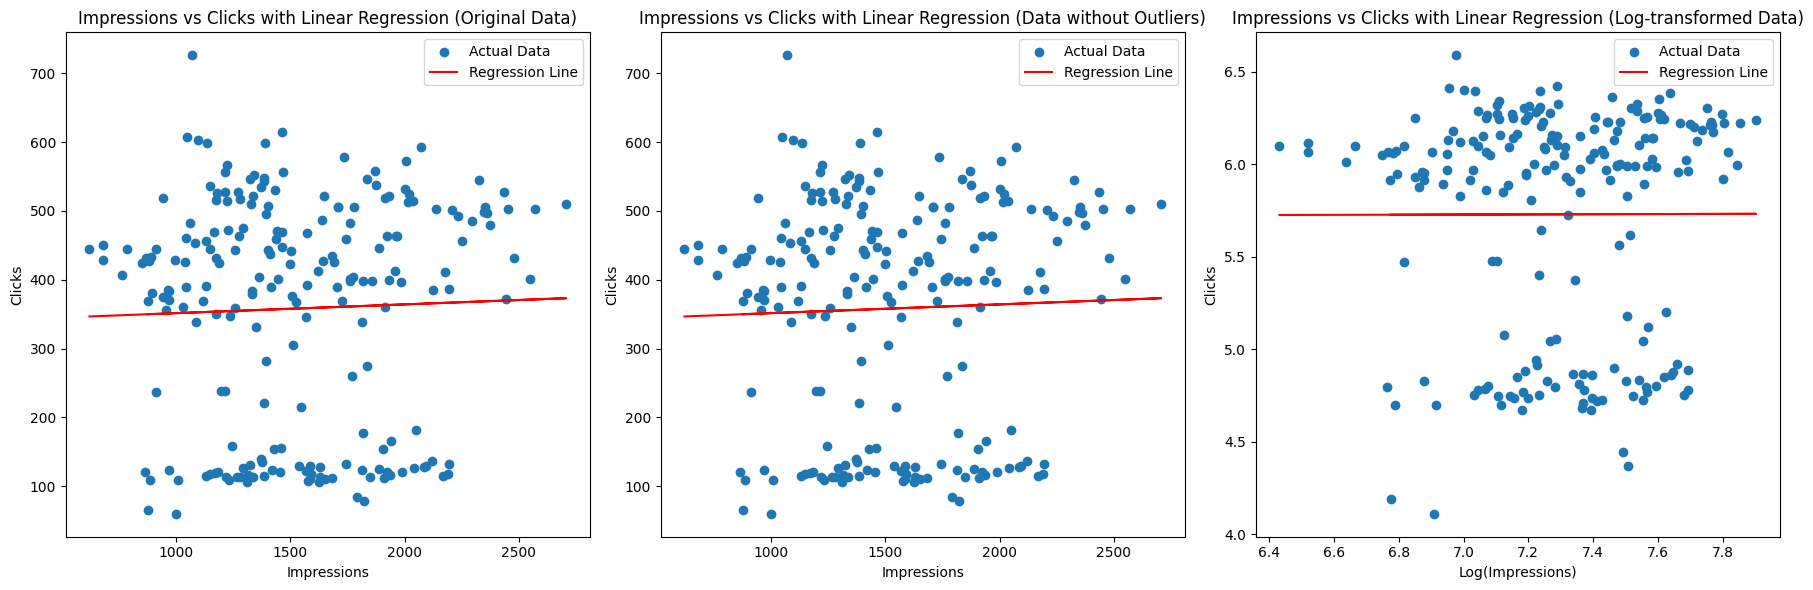

The slope of the linear regression model (Original Data) is: 0.012709310479620622
The slope of the linear regression model (Data without Outliers) is: 0.012709310479620622
The slope of the linear regression model (Log-transformed Data) is: 0.004241626376529049


In [324]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Original data
x = df["Impressions"].values.reshape(-1, 1)
y = df["Clicks"].values

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
slope_original = model.coef_[0]

plt.figure(figsize=(18, 6))

plt.subplot(131)  # subplot for original data
plt.scatter(df['Impressions'], df['Clicks'], label='Actual Data')
plt.plot(df['Impressions'], y_pred, color='red', label='Regression Line')
plt.title('Impressions vs Clicks with Linear Regression (Original Data)')
plt.xlabel('Impressions')
plt.ylabel('Clicks')
plt.legend()

# Data without outliers
x_no_outlier = df_without_outlier["Impressions"].values.reshape(-1, 1)
y_no_outlier = df_without_outlier["Clicks"].values

model.fit(x_no_outlier, y_no_outlier)
y_pred_no_outlier = model.predict(x_no_outlier)
slope_no_outlier = model.coef_[0]

plt.subplot(132)  # subplot for data without outliers
plt.scatter(df_without_outlier['Impressions'], df_without_outlier['Clicks'], label='Actual Data')
plt.plot(df_without_outlier['Impressions'], y_pred_no_outlier, color='red', label='Regression Line')
plt.title('Impressions vs Clicks with Linear Regression (Data without Outliers)')
plt.xlabel('Impressions')
plt.ylabel('Clicks')
plt.legend()

# Log-transformed data
x_log = df_log["Impressions"].values.reshape(-1, 1)
y_log = df_log["Clicks"].values

model.fit(x_log, y_log)
y_pred_log = model.predict(x_log)
slope_log = model.coef_[0]

plt.subplot(133)  # subplot for log-transformed data
plt.scatter(df_log['Impressions'], df_log['Clicks'], label='Actual Data')
plt.plot(df_log['Impressions'], y_pred_log, color='red', label='Regression Line')
plt.title('Impressions vs Clicks with Linear Regression (Log-transformed Data)')
plt.xlabel('Log(Impressions)')
plt.ylabel('Clicks')
plt.legend()

plt.tight_layout()
plt.show()

# Print slopes
print(f"The slope of the linear regression model (Original Data) is: {slope_original}")
print(f"The slope of the linear regression model (Data without Outliers) is: {slope_no_outlier}")
print(f"The slope of the linear regression model (Log-transformed Data) is: {slope_log}")


Hence the slope is +ve and thus proves the hypothesis that More impressions leads to more clicks.
***

***
# EDA

## 1. Day wise plot for all 7 month data

#### 1.1 For Quantity

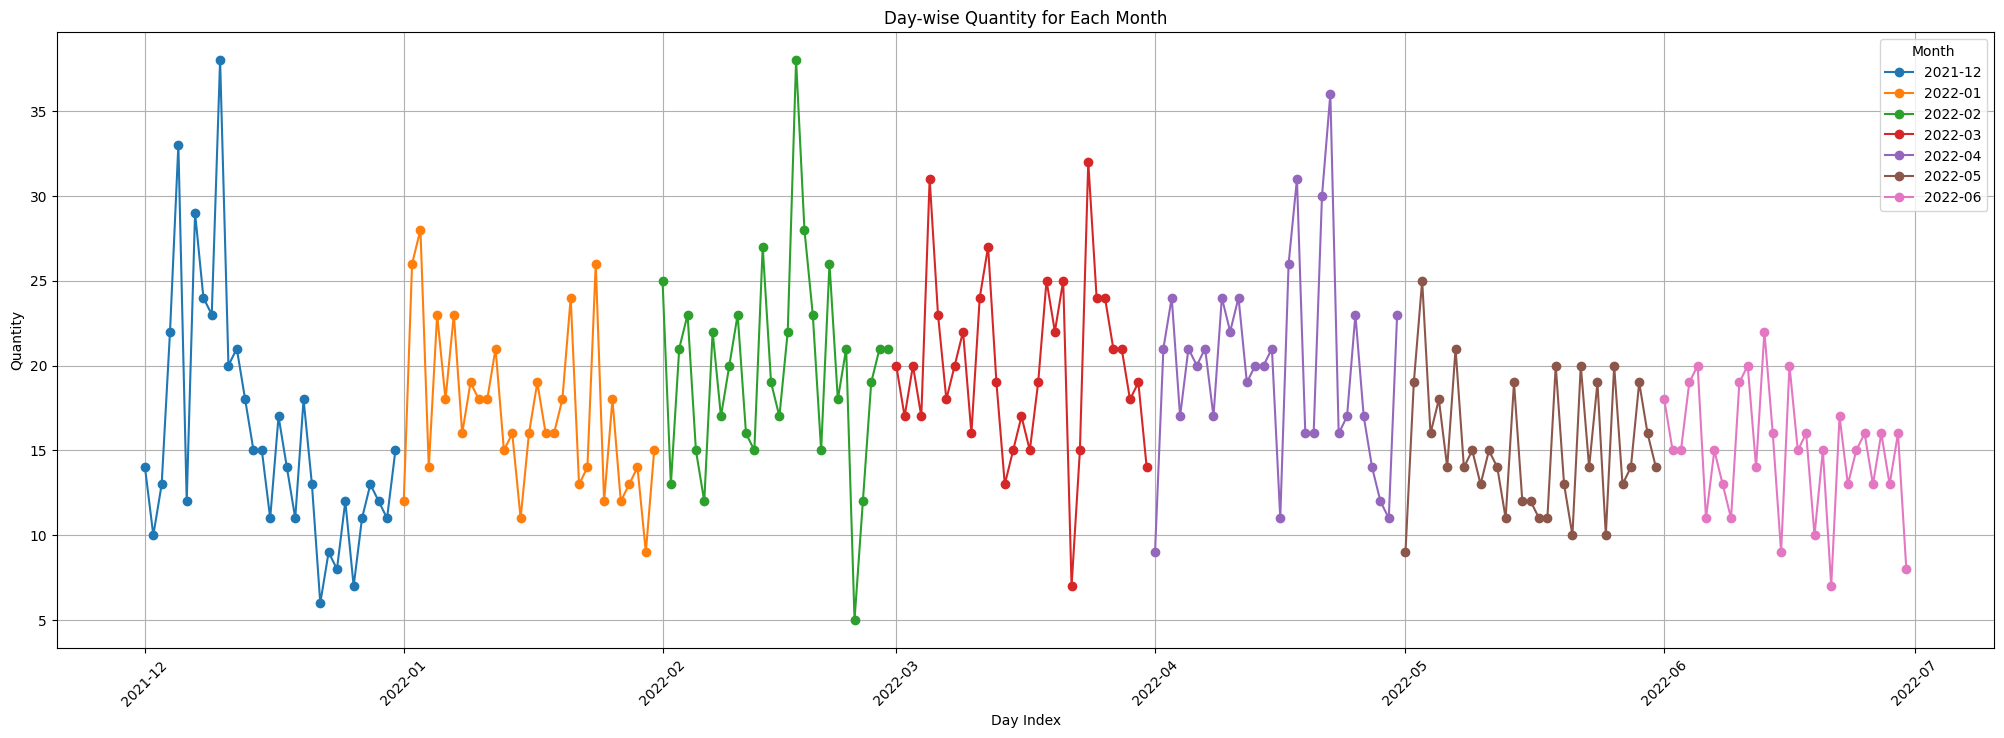

In [304]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Day Index' is in datetime format
df['Day Index'] = pd.to_datetime(df['Day Index'])

# Extract month and year
df['YearMonth'] = df['Day Index'].dt.to_period('M')

# Create a figure
plt.figure(figsize=(25, 8))

# Iterate over each month and plot the data
for month in df['YearMonth'].unique():
    monthly_data = df[df['YearMonth'] == month]
    plt.plot(monthly_data['Day Index'], monthly_data['Quantity'], marker='o', linestyle='-', label=str(month))

# Add title and labels
plt.title('Day-wise Quantity for Each Month')
plt.xlabel('Day Index')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend(title='Month', loc='best')
plt.grid(True)

# Show the plot
plt.show()


#### 1.2 For Clicks

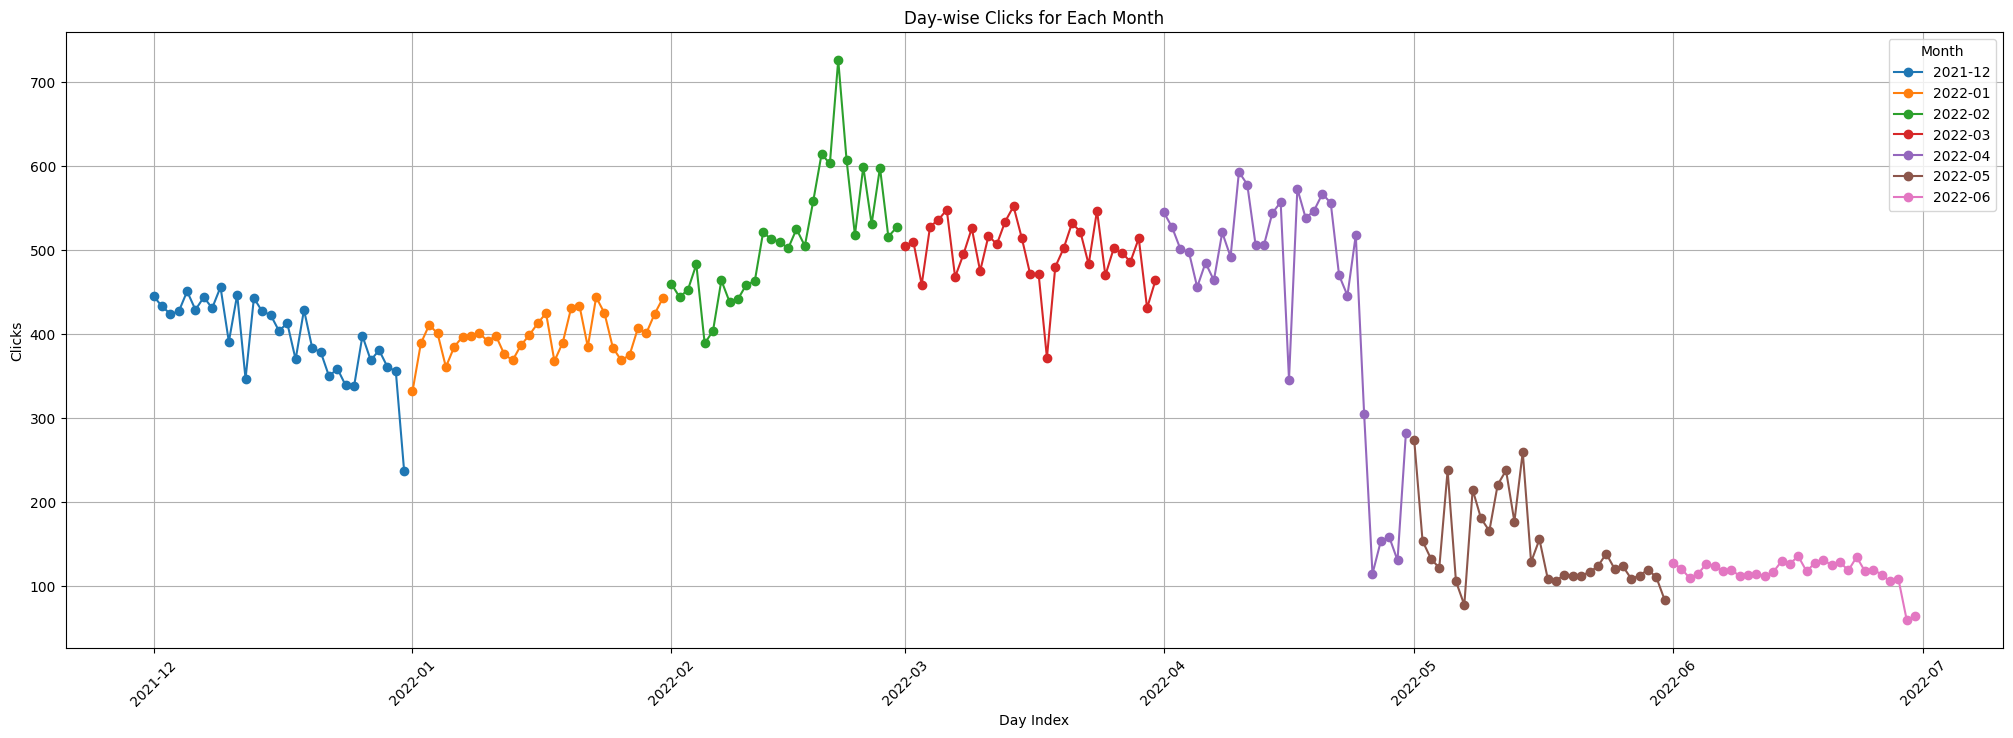

In [325]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Day Index' is in datetime format
df['Day Index'] = pd.to_datetime(df['Day Index'])

# Extract month and year
df['YearMonth'] = df['Day Index'].dt.to_period('M')

# Create a figure
plt.figure(figsize=(25, 8))

# Iterate over each month and plot the data
for month in df['YearMonth'].unique():
    monthly_data = df[df['YearMonth'] == month]
    plt.plot(monthly_data['Day Index'], monthly_data['Clicks'], marker='o', linestyle='-', label=str(month))

# Add title and labels
plt.title('Day-wise Clicks for Each Month')
plt.xlabel('Day Index')
plt.ylabel('Clicks')
plt.xticks(rotation=45)
plt.legend(title='Month', loc='best')
plt.grid(True)

# Show the plot
plt.show()


#### 1.3 For Impressions

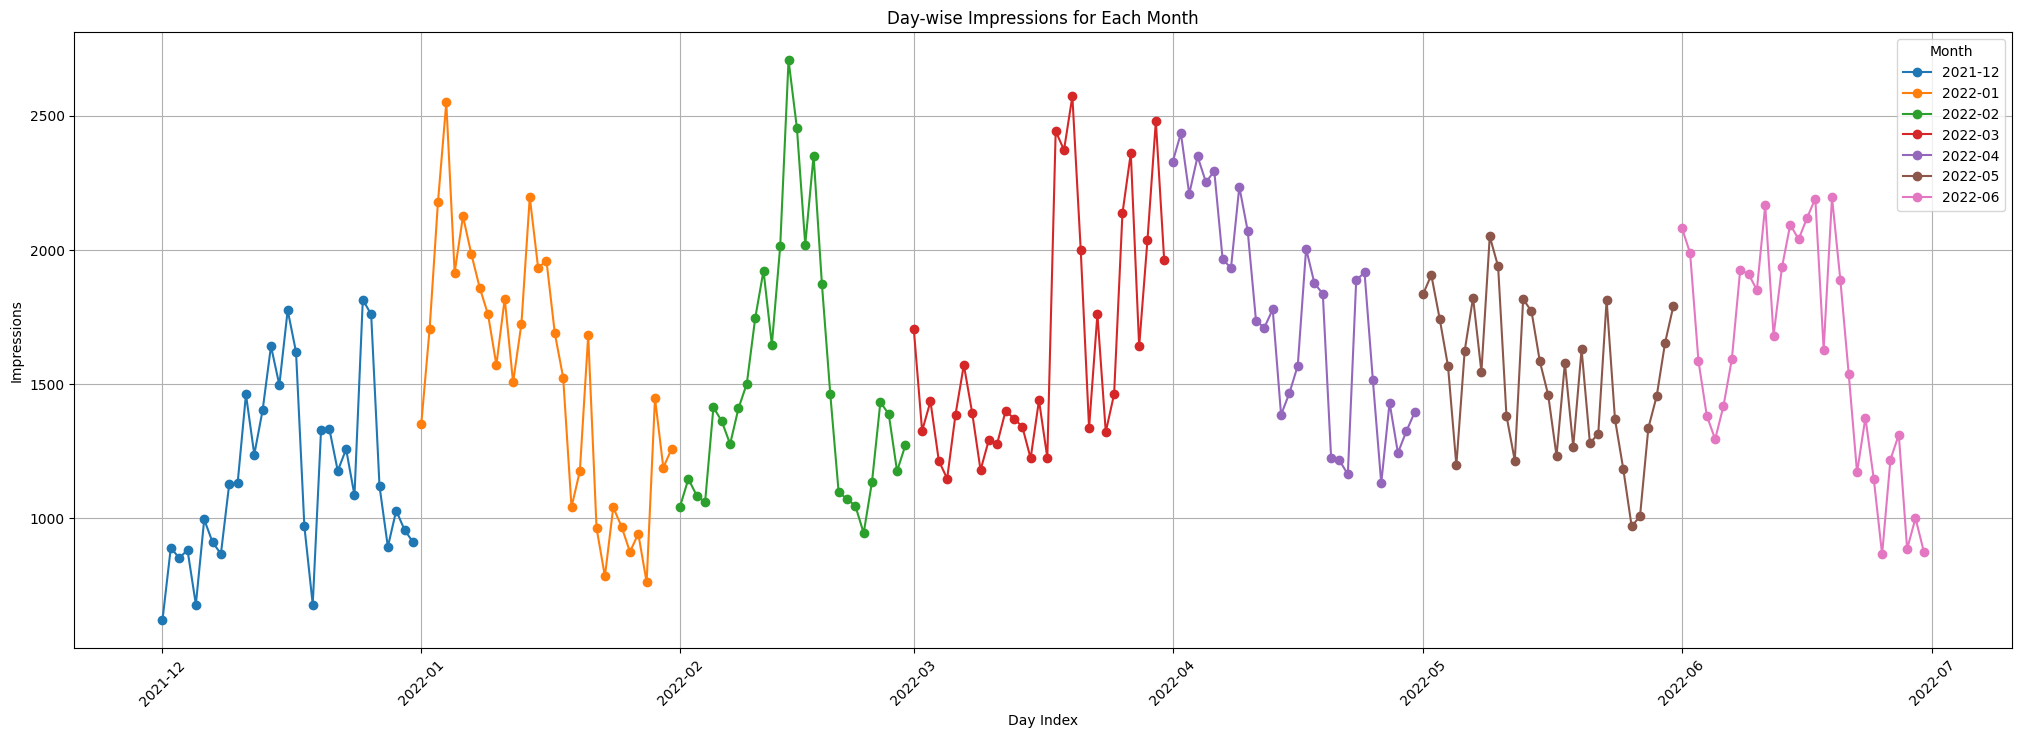

In [326]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Day Index' is in datetime format
df['Day Index'] = pd.to_datetime(df['Day Index'])

# Extract month and year
df['YearMonth'] = df['Day Index'].dt.to_period('M')

# Create a figure
plt.figure(figsize=(25, 8))

# Iterate over each month and plot the data
for month in df['YearMonth'].unique():
    monthly_data = df[df['YearMonth'] == month]
    plt.plot(monthly_data['Day Index'], monthly_data['Impressions'], marker='o', linestyle='-', label=str(month))

# Add title and labels
plt.title('Day-wise Impressions for Each Month')
plt.xlabel('Day Index')
plt.ylabel('Impressions')
plt.xticks(rotation=45)
plt.legend(title='Month', loc='best')
plt.grid(True)

# Show the plot
plt.show()


## 2. Aggregated Monthly day wise plot

#### 2.1 For Quantity

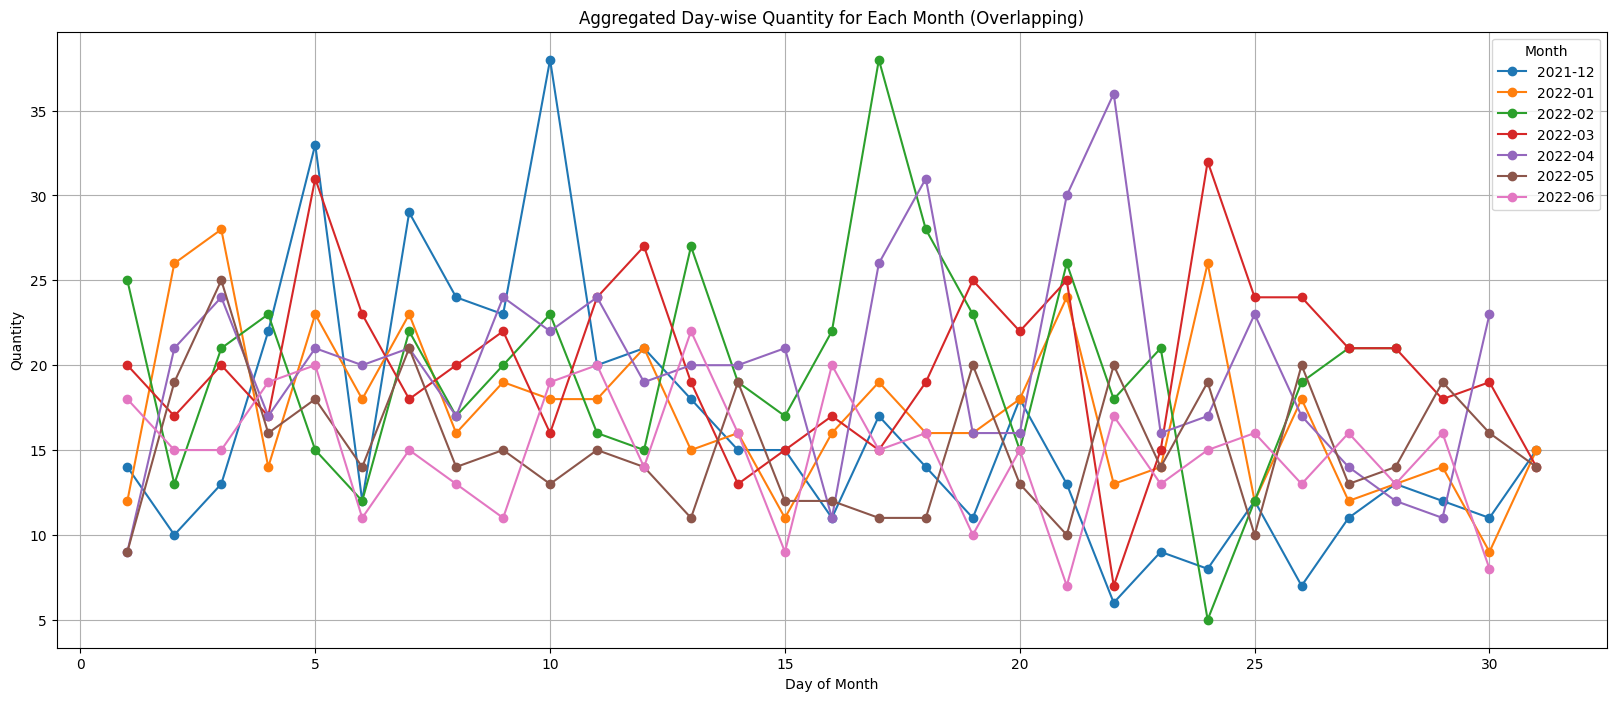

In [305]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Day Index' is in datetime format
df['Day Index'] = pd.to_datetime(df['Day Index'])

# Extract month and year
df['YearMonth'] = df['Day Index'].dt.to_period('M')

# Extract day of the month
df['DayOfMonth'] = df['Day Index'].dt.day

# Create a figure
plt.figure(figsize=(20, 8))

# Iterate over each month and plot the data
for month in df['YearMonth'].unique():
    monthly_data = df[df['YearMonth'] == month]
    plt.plot(monthly_data['DayOfMonth'], monthly_data['Quantity'], marker='o', linestyle='-', label=str(month))

# Add title and labels
plt.title('Aggregated Day-wise Quantity for Each Month (Overlapping)')
plt.xlabel('Day of Month')
plt.ylabel('Quantity')
plt.legend(title='Month', loc='best')
plt.grid(True)

# Show the plot
plt.show()


#### 2.2 For CLicks

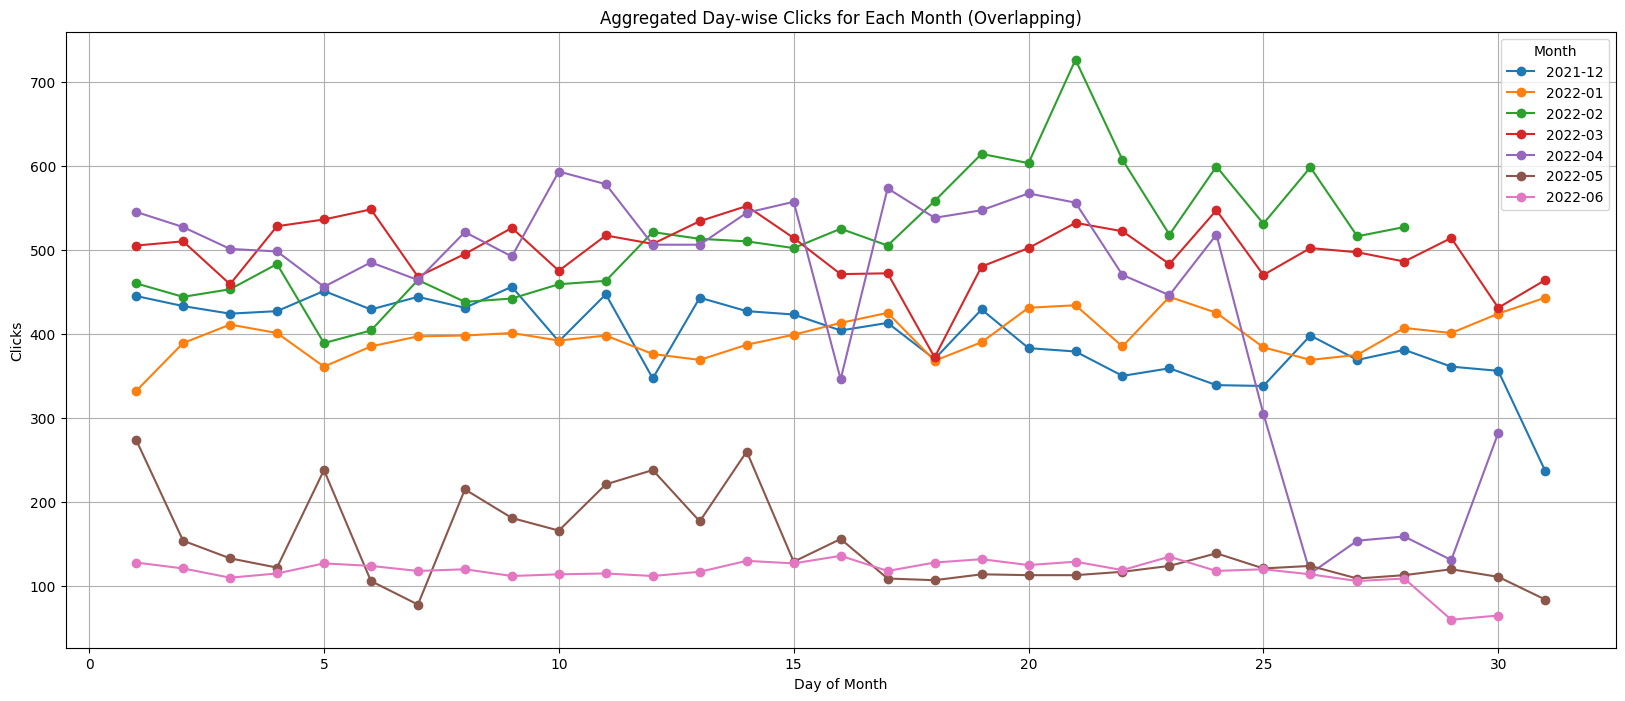

In [327]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Day Index' is in datetime format
df['Day Index'] = pd.to_datetime(df['Day Index'])

# Extract month and year
df['YearMonth'] = df['Day Index'].dt.to_period('M')

# Extract day of the month
df['DayOfMonth'] = df['Day Index'].dt.day

# Create a figure
plt.figure(figsize=(20, 8))

# Iterate over each month and plot the data
for month in df['YearMonth'].unique():
    monthly_data = df[df['YearMonth'] == month]
    plt.plot(monthly_data['DayOfMonth'], monthly_data['Clicks'], marker='o', linestyle='-', label=str(month))

# Add title and labels
plt.title('Aggregated Day-wise Clicks for Each Month (Overlapping)')
plt.xlabel('Day of Month')
plt.ylabel('Clicks')
plt.legend(title='Month', loc='best')
plt.grid(True)

# Show the plot
plt.show()


#### 2.3 For Impressions

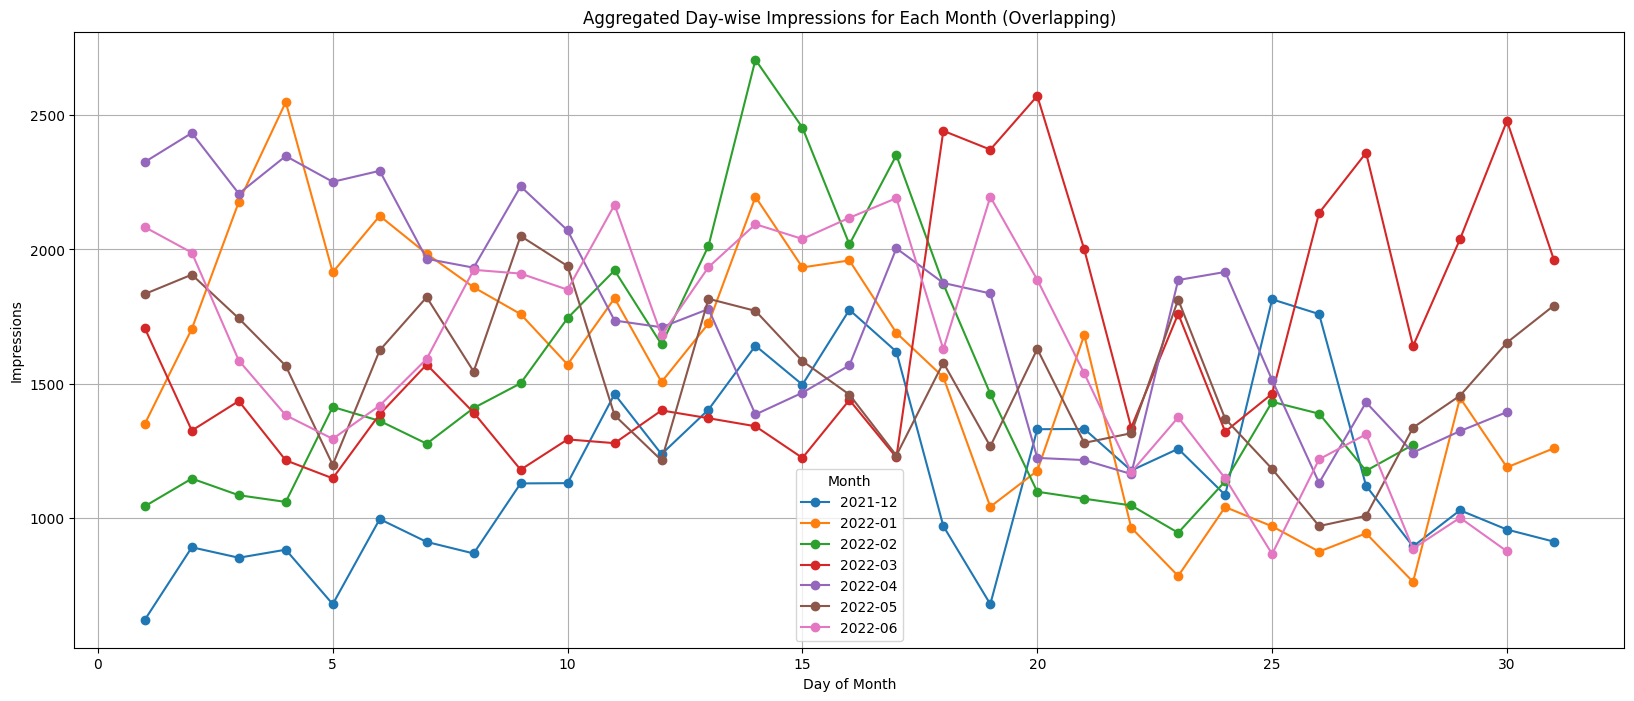

In [328]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Day Index' is in datetime format
df['Day Index'] = pd.to_datetime(df['Day Index'])

# Extract month and year
df['YearMonth'] = df['Day Index'].dt.to_period('M')

# Extract day of the month
df['DayOfMonth'] = df['Day Index'].dt.day

# Create a figure
plt.figure(figsize=(20, 8))

# Iterate over each month and plot the data
for month in df['YearMonth'].unique():
    monthly_data = df[df['YearMonth'] == month]
    plt.plot(monthly_data['DayOfMonth'], monthly_data['Impressions'], marker='o', linestyle='-', label=str(month))

# Add title and labels
plt.title('Aggregated Day-wise Impressions for Each Month (Overlapping)')
plt.xlabel('Day of Month')
plt.ylabel('Impressions')
plt.legend(title='Month', loc='best')
plt.grid(True)

# Show the plot
plt.show()


## 3. Monthly plot

#### 3.1 For quantity

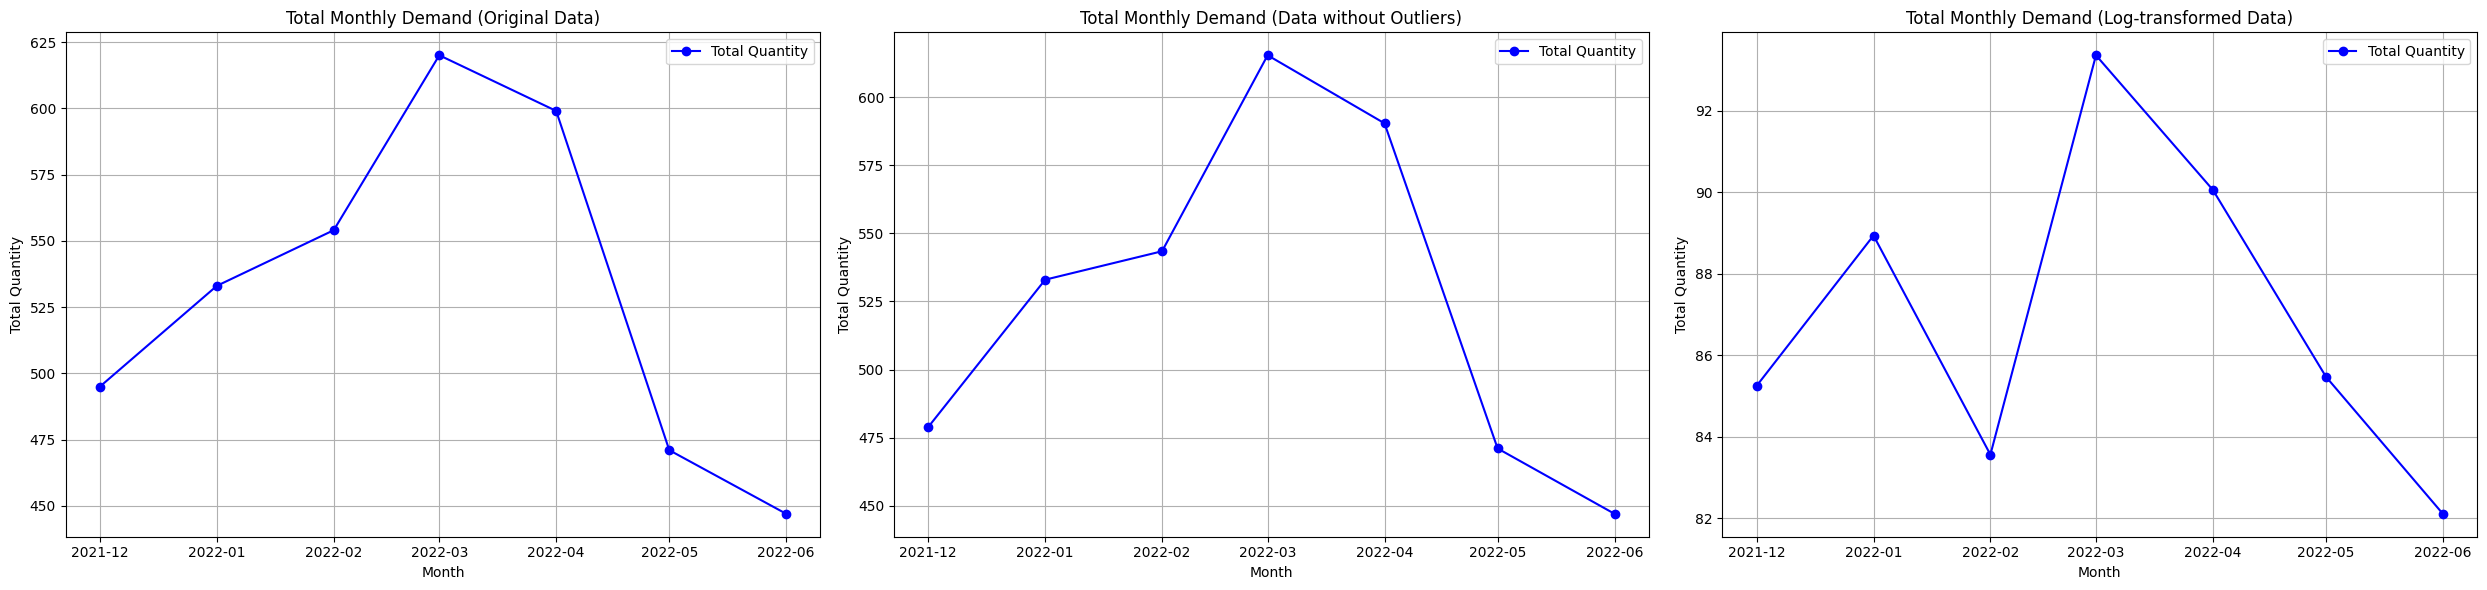

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Original data
df['Day Index'] = pd.to_datetime(df['Day Index'])

# Extract month and year
df['YearMonth'] = df['Day Index'].dt.to_period('M')

# Group by month and sum the quantities
monthly_demand_original = df.groupby('YearMonth')['Quantity'].sum().reset_index()

# Convert YearMonth to datetime for plotting
monthly_demand_original['YearMonth'] = monthly_demand_original['YearMonth'].dt.to_timestamp()

# Data without outliers
df_without_outlier['Day Index'] = pd.to_datetime(df_without_outlier['Day Index'])

# Extract month and year
df_without_outlier['YearMonth'] = df_without_outlier['Day Index'].dt.to_period('M')

# Group by month and sum the quantities
monthly_demand_without_outliers = df_without_outlier.groupby('YearMonth')['Quantity'].sum().reset_index()

# Convert YearMonth to datetime for plotting
monthly_demand_without_outliers['YearMonth'] = monthly_demand_without_outliers['YearMonth'].dt.to_timestamp()

# Log-transformed data
df_log['Day Index'] = pd.to_datetime(df_log['Day Index'])

# Extract month and year
df_log['YearMonth'] = df_log['Day Index'].dt.to_period('M')

# Group by month and sum the quantities
monthly_demand_log = df_log.groupby('YearMonth')['Quantity'].sum().reset_index()

# Convert YearMonth to datetime for plotting
monthly_demand_log['YearMonth'] = monthly_demand_log['YearMonth'].dt.to_timestamp()

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

# Plot for original data
axes[0].plot(monthly_demand_original['YearMonth'], monthly_demand_original['Quantity'], marker='o', color='blue', label='Total Quantity')
axes[0].set_title('Total Monthly Demand (Original Data)')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Quantity')
axes[0].grid(True)
axes[0].legend()

# Plot for data without outliers
axes[1].plot(monthly_demand_without_outliers['YearMonth'], monthly_demand_without_outliers['Quantity'], marker='o', color='blue', label='Total Quantity')
axes[1].set_title('Total Monthly Demand (Data without Outliers)')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Total Quantity')
axes[1].grid(True)
axes[1].legend()

# Plot for log-transformed data
axes[2].plot(monthly_demand_log['YearMonth'], monthly_demand_log['Quantity'], marker='o', color='blue', label='Total Quantity')
axes[2].set_title('Total Monthly Demand (Log-transformed Data)')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Total Quantity')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()


* Hence, the total quantity demanded of Product A increases as winters arrive and reaches its peak in March and then declines rapidly.
* Peak 1 --> March (03-2022)
* Peak 2 --> April (04-2022)
***

#### 3.2 For quantity, clicks and impressions aggregated plot

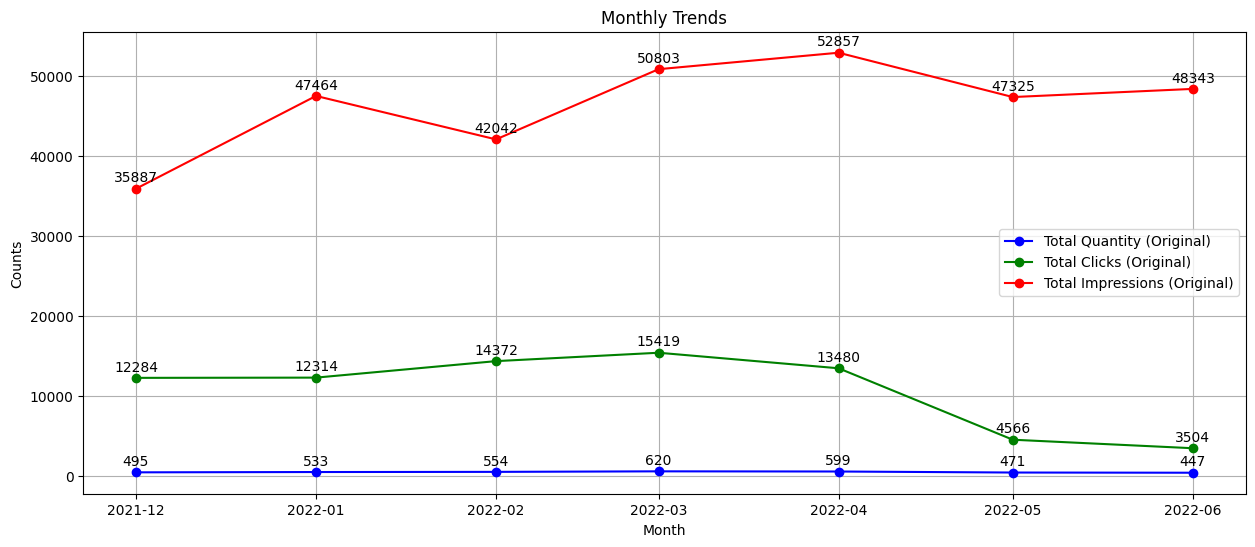

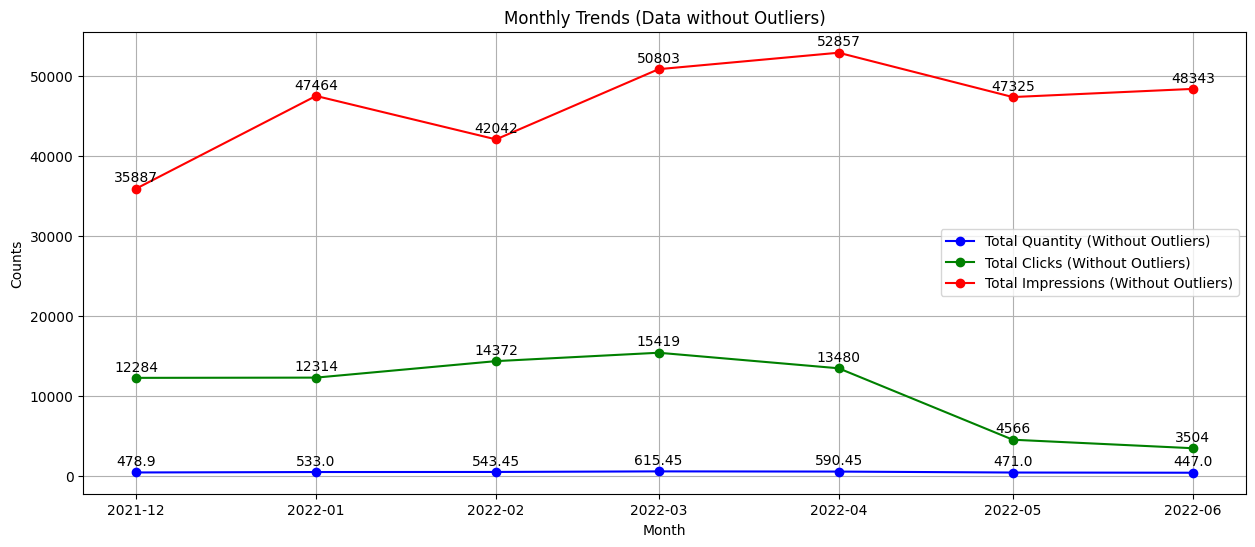

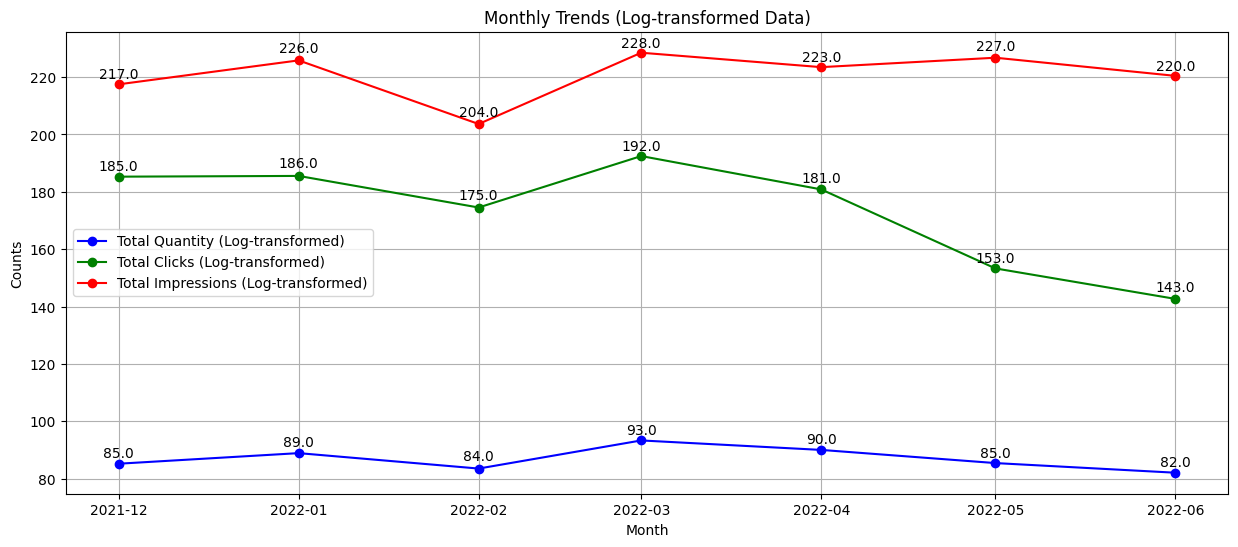

In [319]:
import pandas as pd
import matplotlib.pyplot as plt

# Original data
df['Day Index'] = pd.to_datetime(df['Day Index'])

# Extract month and year
df['YearMonth'] = df['Day Index'].dt.to_period('M')

# Group by month and sum the quantities
monthly_demand_original = df.groupby('YearMonth').agg({
    'Quantity': 'sum',
    'Clicks': 'sum',
    'Impressions': 'sum'
}).reset_index()

# Convert YearMonth to datetime for plotting
monthly_demand_original['YearMonth'] = monthly_demand_original['YearMonth'].dt.to_timestamp()

# Data without outliers
df_without_outlier['Day Index'] = pd.to_datetime(df_without_outlier['Day Index'])

# Extract month and year
df_without_outlier['YearMonth'] = df_without_outlier['Day Index'].dt.to_period('M')

# Group by month and sum the quantities
monthly_demand_without_outliers = df_without_outlier.groupby('YearMonth').agg({
    'Quantity': 'sum',
    'Clicks': 'sum',
    'Impressions': 'sum'
}).reset_index()

# Convert YearMonth to datetime for plotting
monthly_demand_without_outliers['YearMonth'] = monthly_demand_without_outliers['YearMonth'].dt.to_timestamp()

# Log-transformed data
df_log['Day Index'] = pd.to_datetime(df_log['Day Index'])

# Extract month and year
df_log['YearMonth'] = df_log['Day Index'].dt.to_period('M')

# Group by month and sum the quantities
monthly_demand_log = df_log.groupby('YearMonth').agg({
    'Quantity': 'sum',
    'Clicks': 'sum',
    'Impressions': 'sum'
}).reset_index()

# Convert YearMonth to datetime for plotting
monthly_demand_log['YearMonth'] = monthly_demand_log['YearMonth'].dt.to_timestamp()

# Function to annotate points with their values
def annotate_points(ax, x, y, values):
    for i, txt in enumerate(values):
        ax.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(0,5), ha='center')

# Plotting each graph separately
plt.figure(figsize=(15, 6))

# Plot for original data
plt.plot(monthly_demand_original['YearMonth'], monthly_demand_original['Quantity'], marker='o', color='blue', label='Total Quantity (Original)')
annotate_points(plt.gca(), monthly_demand_original['YearMonth'], monthly_demand_original['Quantity'], monthly_demand_original['Quantity'])
plt.plot(monthly_demand_original['YearMonth'], monthly_demand_original['Clicks'], marker='o', color='green', label='Total Clicks (Original)')
annotate_points(plt.gca(), monthly_demand_original['YearMonth'], monthly_demand_original['Clicks'], monthly_demand_original['Clicks'])
plt.plot(monthly_demand_original['YearMonth'], monthly_demand_original['Impressions'], marker='o', color='red', label='Total Impressions (Original)')
annotate_points(plt.gca(), monthly_demand_original['YearMonth'], monthly_demand_original['Impressions'], monthly_demand_original['Impressions'])

plt.title('Monthly Trends')
plt.xlabel('Month')
plt.ylabel('Counts')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))

# Plot for data without outliers
plt.plot(monthly_demand_without_outliers['YearMonth'], monthly_demand_without_outliers['Quantity'], marker='o', color='blue', label='Total Quantity (Without Outliers)')
annotate_points(plt.gca(), monthly_demand_without_outliers['YearMonth'], monthly_demand_without_outliers['Quantity'], monthly_demand_without_outliers['Quantity'])
plt.plot(monthly_demand_without_outliers['YearMonth'], monthly_demand_without_outliers['Clicks'], marker='o', color='green', label='Total Clicks (Without Outliers)')
annotate_points(plt.gca(), monthly_demand_without_outliers['YearMonth'], monthly_demand_without_outliers['Clicks'], monthly_demand_without_outliers['Clicks'])
plt.plot(monthly_demand_without_outliers['YearMonth'], monthly_demand_without_outliers['Impressions'], marker='o', color='red', label='Total Impressions (Without Outliers)')
annotate_points(plt.gca(), monthly_demand_without_outliers['YearMonth'], monthly_demand_without_outliers['Impressions'], monthly_demand_without_outliers['Impressions'])

plt.title('Monthly Trends (Data without Outliers)')
plt.xlabel('Month')
plt.ylabel('Counts')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))

# Plot for log-transformed data
plt.plot(monthly_demand_log['YearMonth'], monthly_demand_log['Quantity'], marker='o', color='blue', label='Total Quantity (Log-transformed)')
annotate_points(plt.gca(), monthly_demand_log['YearMonth'], monthly_demand_log['Quantity'].round(decimals=0), monthly_demand_log['Quantity'].round(decimals=0))
plt.plot(monthly_demand_log['YearMonth'], monthly_demand_log['Clicks'], marker='o', color='green', label='Total Clicks (Log-transformed)')
annotate_points(plt.gca(), monthly_demand_log['YearMonth'], monthly_demand_log['Clicks'].round(decimals=0), monthly_demand_log['Clicks'].round(decimals=0))
plt.plot(monthly_demand_log['YearMonth'], monthly_demand_log['Impressions'], marker='o', color='red', label='Total Impressions (Log-transformed)')
annotate_points(plt.gca(), monthly_demand_log['YearMonth'], monthly_demand_log['Impressions'].round(decimals=0), monthly_demand_log['Impressions'].round(decimals=0))

plt.title('Monthly Trends (Log-transformed Data)')
plt.xlabel('Month')
plt.ylabel('Counts')
plt.grid(True)
plt.legend()
plt.show()


* As we can see in the above log transformed one, we can see that in the month of march (03-2022), all 3 attributes hit their peaks.
* Meanwhile in all 3 plots, impressions and quantity peaks in march .

## 4. Weekly day wise plot

#### 4.1 For Quantity

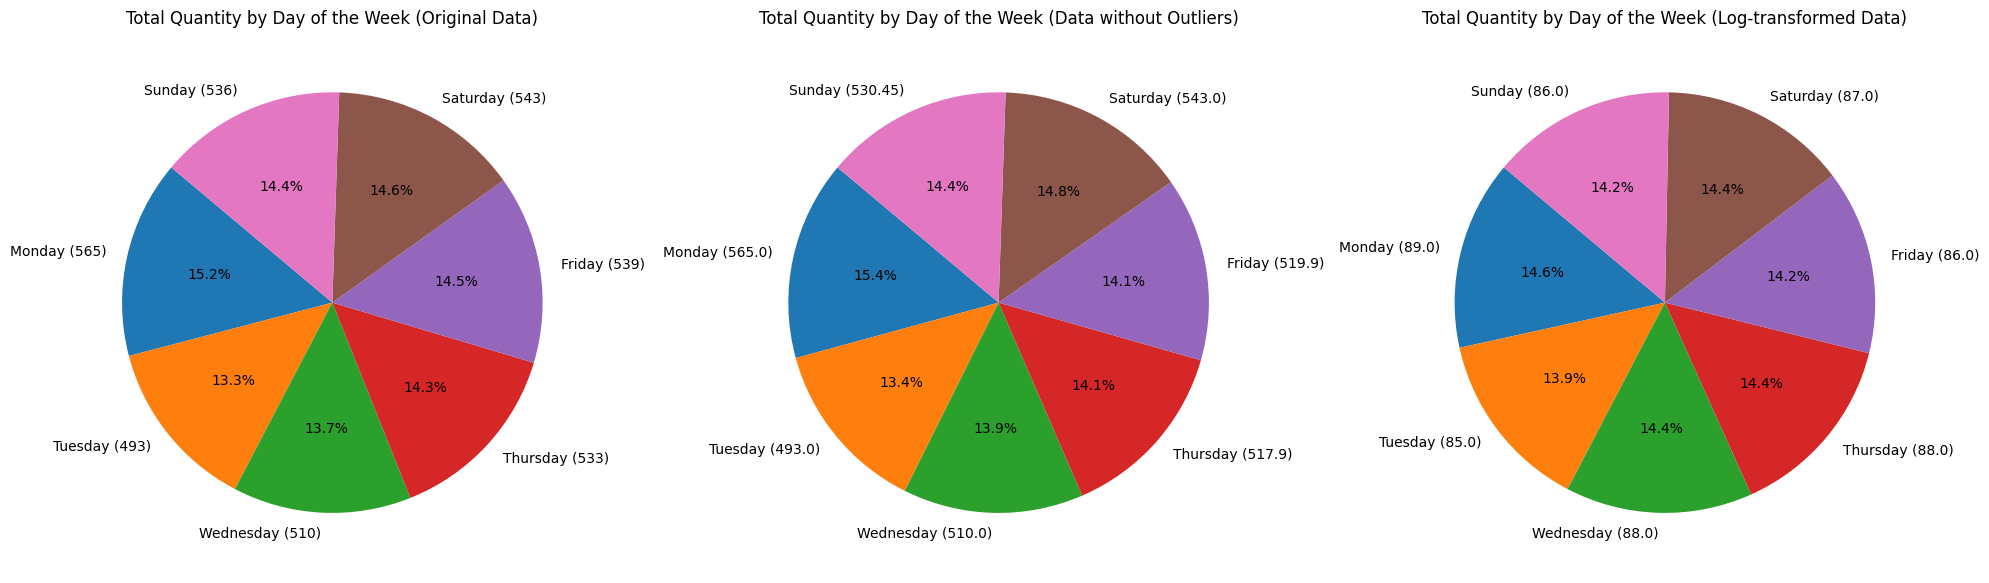

In [331]:
import pandas as pd
import matplotlib.pyplot as plt

# Original data
df['Day Index'] = pd.to_datetime(df['Day Index'])
df['DayOfWeek'] = df['Day Index'].dt.day_name()
day_of_week_demand = df.groupby('DayOfWeek')['Quantity'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(20, 6))

plt.subplot(131)  # subplot for original data
labels_original = [f'{day} ({qty})' for day, qty in zip(day_of_week_demand.index, day_of_week_demand)]
plt.pie(day_of_week_demand, labels=labels_original, autopct='%1.1f%%', startangle=140)
plt.title('Total Quantity by Day of the Week (Original Data)')
plt.axis('equal')

# Data without outliers
df_without_outlier['Day Index'] = pd.to_datetime(df_without_outlier['Day Index'])
df_without_outlier['DayOfWeek'] = df_without_outlier['Day Index'].dt.day_name()
day_of_week_demand_no_outlier = df_without_outlier.groupby('DayOfWeek')['Quantity'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.subplot(132)  # subplot for data without outliers
labels_no_outlier = [f'{day} ({qty})' for day, qty in zip(day_of_week_demand_no_outlier.index, day_of_week_demand_no_outlier)]
plt.pie(day_of_week_demand_no_outlier, labels=labels_no_outlier, autopct='%1.1f%%', startangle=140)
plt.title('Total Quantity by Day of the Week (Data without Outliers)')
plt.axis('equal')

# Log-transformed data
df_log['Day Index'] = pd.to_datetime(df_log['Day Index'])
df_log['DayOfWeek'] = df_log['Day Index'].dt.day_name()
day_of_week_demand_log = df_log.groupby('DayOfWeek')['Quantity'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.subplot(133)  # subplot for log-transformed data
labels_log = [f'{day} ({qty})' for day, qty in zip(day_of_week_demand_log.index, day_of_week_demand_log.round(decimals=0))]
plt.pie(day_of_week_demand_log, labels=labels_log, autopct='%1.1f%%', startangle=140)
plt.title('Total Quantity by Day of the Week (Log-transformed Data)')
plt.axis('equal')

plt.tight_layout()
plt.show()


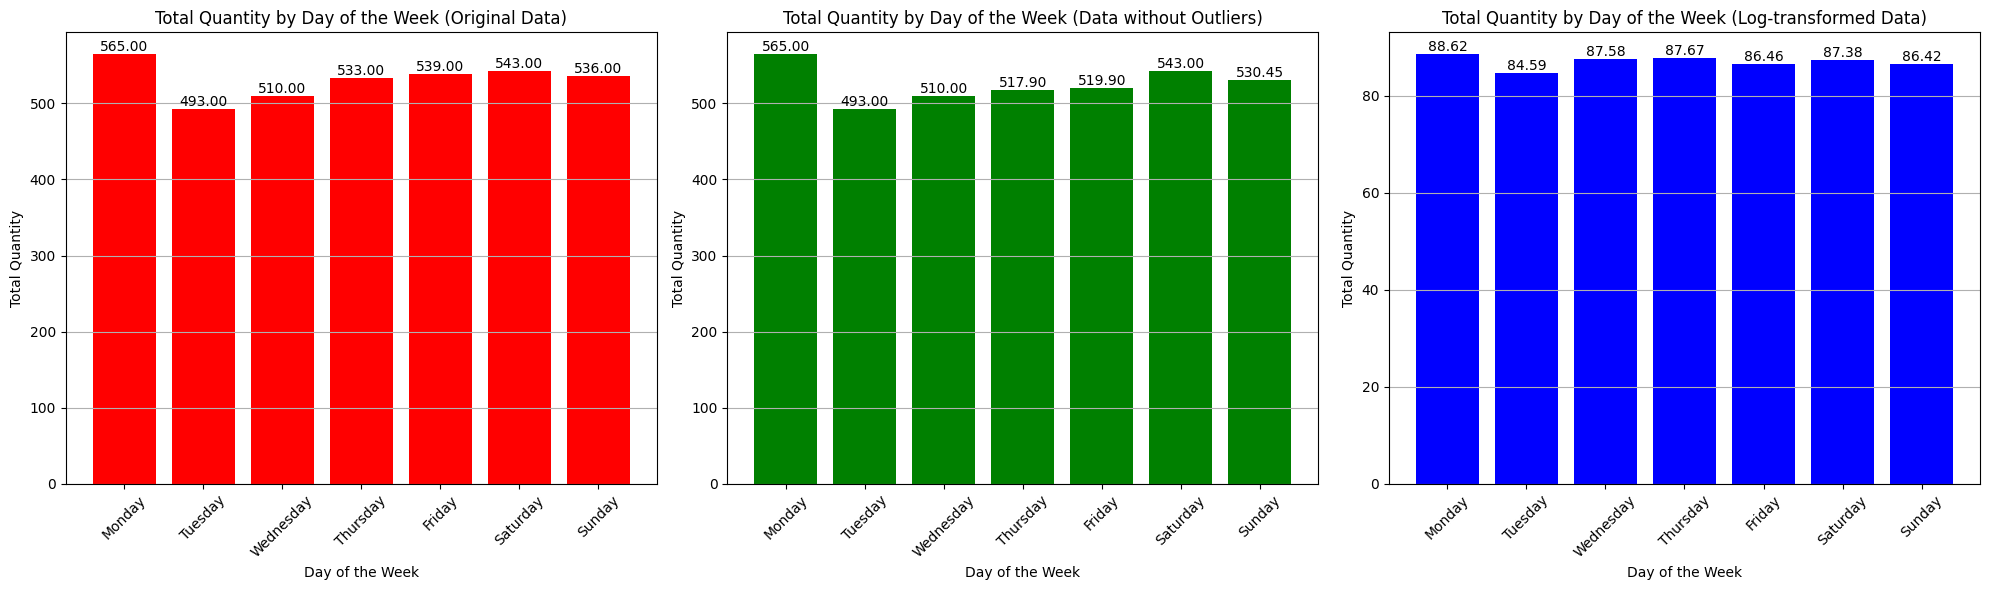

In [358]:

# Original data
df['Day Index'] = pd.to_datetime(df['Day Index'])
df['DayOfWeek'] = df['Day Index'].dt.day_name()
day_of_week_demand = df.groupby('DayOfWeek')['Quantity'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(20, 6))

plt.subplot(131)  # subplot for original data
bars = plt.bar(day_of_week_demand.index, day_of_week_demand, color='red')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
plt.title('Total Quantity by Day of the Week (Original Data)')
plt.xlabel('Day of the Week')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Data without outliers
df_without_outlier['Day Index'] = pd.to_datetime(df_without_outlier['Day Index'])
df_without_outlier['DayOfWeek'] = df_without_outlier['Day Index'].dt.day_name()
day_of_week_demand_no_outlier = df_without_outlier.groupby('DayOfWeek')['Quantity'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.subplot(132)  # subplot for data without outliers
bars_no_outlier = plt.bar(day_of_week_demand_no_outlier.index, day_of_week_demand_no_outlier, color='green')
for bar in bars_no_outlier:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
plt.title('Total Quantity by Day of the Week (Data without Outliers)')
plt.xlabel('Day of the Week')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Log-transformed data
df_log['Day Index'] = pd.to_datetime(df_log['Day Index'])
df_log['DayOfWeek'] = df_log['Day Index'].dt.day_name()
day_of_week_demand_log = df_log.groupby('DayOfWeek')['Quantity'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.subplot(133)  # subplot for log-transformed data
bars_log = plt.bar(day_of_week_demand_log.index, day_of_week_demand_log, color='blue')
for bar in bars_log:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
plt.title('Total Quantity by Day of the Week (Log-transformed Data)')
plt.xlabel('Day of the Week')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

As we can derive 2 conclusions from the total Product's quantity of each day:
* Monday accounts for the highest Product's quantity demand.
* Tuesdays accounts for the lowest Product's quantity demand.

***

#### 4.2 For Quantity, Clicks and Impressions Aggregated

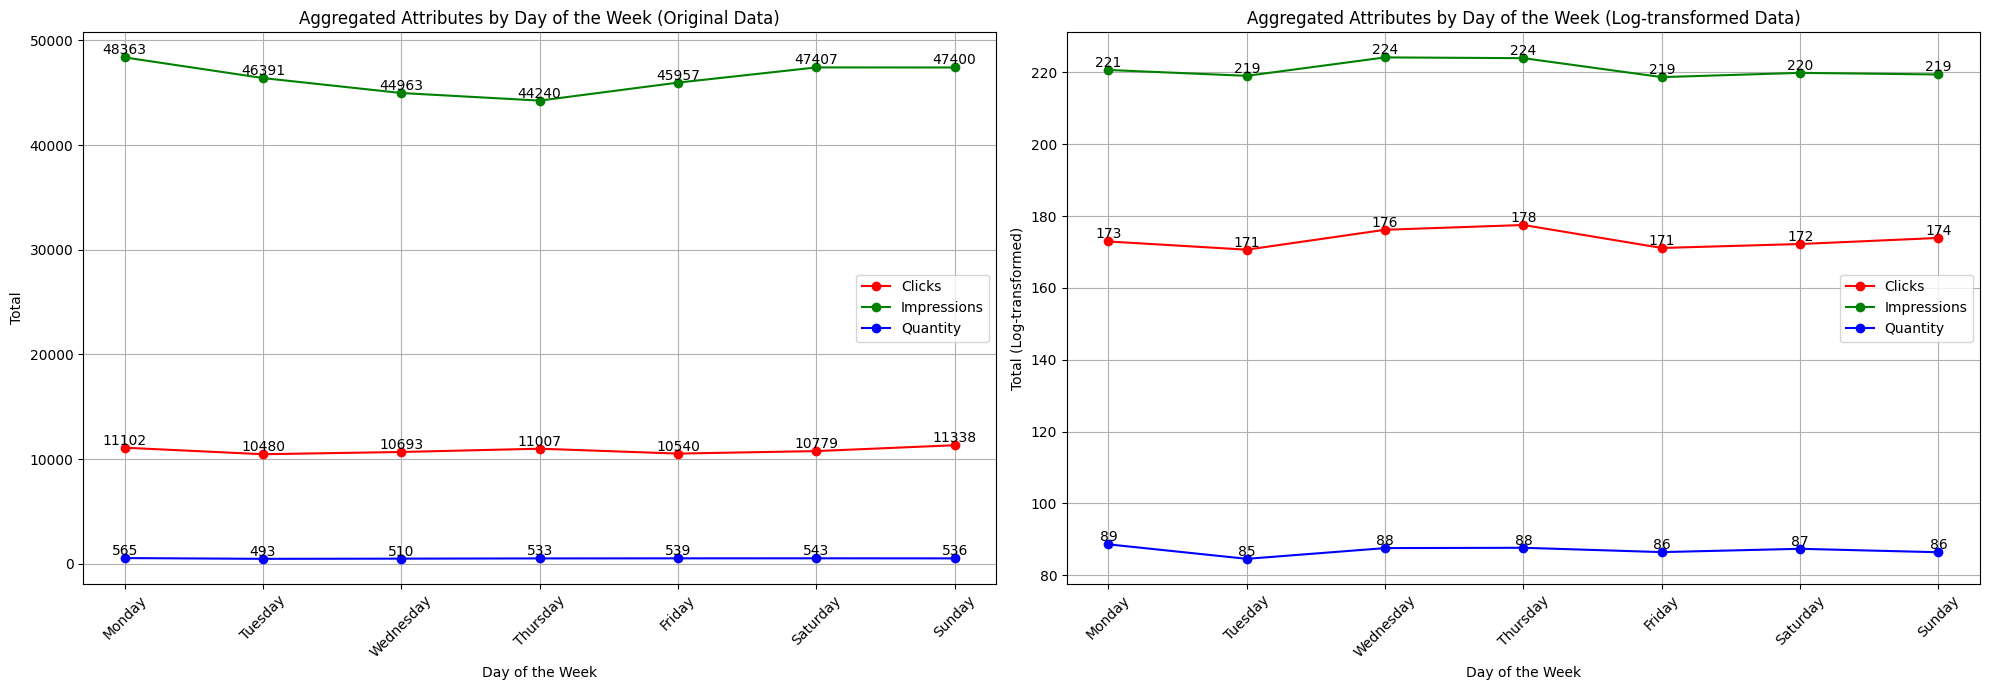

In [370]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df and df_log are already defined with necessary columns

# Ensure Day Index is a datetime object
df['Day Index'] = pd.to_datetime(df['Day Index'])
df['DayOfWeek'] = df['Day Index'].dt.day_name()

df_log['Day Index'] = pd.to_datetime(df_log['Day Index'])
df_log['DayOfWeek'] = df_log['Day Index'].dt.day_name()

# Group by day of the week and sum the attributes
day_of_week_data_original = df.groupby('DayOfWeek')[['Clicks', 'Impressions', 'Quantity']].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

day_of_week_data_log = df_log.groupby('DayOfWeek')[['Clicks', 'Impressions', 'Quantity']].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Original data subplot
index = np.arange(len(day_of_week_data_original.index))

for ax, data, title, ylabel in zip(axes.flatten(), [day_of_week_data_original, day_of_week_data_log],
                                   ['Original Data', 'Log-transformed Data'], ['Total', 'Total (Log-transformed)']):
    ax.plot(index, data['Clicks'], marker='o', linestyle='-', color='red', label='Clicks')
    ax.plot(index, data['Impressions'], marker='o', linestyle='-', color='green', label='Impressions')
    ax.plot(index, data['Quantity'], marker='o', linestyle='-', color='blue', label='Quantity')

    # Annotate points with values
    for i, value in enumerate(data['Clicks']):
        ax.text(index[i], value, f'{value:.0f}', ha='center', va='bottom', fontsize=10)

    for i, value in enumerate(data['Impressions']):
        ax.text(index[i], value, f'{value:.0f}', ha='center', va='bottom', fontsize=10)

    for i, value in enumerate(data['Quantity']):
        ax.text(index[i], value, f'{value:.0f}', ha='center', va='bottom', fontsize=10)

    # Adding labels and title
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel(ylabel)
    ax.set_title(f'Aggregated Attributes by Day of the Week ({title})')
    ax.set_xticks(index)
    ax.set_xticklabels(data.index, rotation=45)  # Set the day names as x-axis labels
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


From the plot, we can derive following conclusions:
* <i>in original data plot</i>
    * Weekends (saturday, sundays) and monday have high impressions and clicks
    * Also, Thursday accounts for highest clicks
* <i>in log-transformed data plot</i> 
    * Wednesday and Thursday accounts for high impressions and clicks 

***
# next
***